In [1]:
## LSTM for stock ##

# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, Input, concatenate
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
from keras import regularizers
from keras import initializers
from keras import constraints
from keras import activations
from keras import losses
from keras import metrics
from keras import optimizers
from keras import callbacks
from keras import layers
from keras import models
from keras import utils
from keras import backend as K

2023-10-04 10:46:14.928374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import mplfinance as mpf

In [81]:
df = pd.read_csv('data.csv', index_col=[0])
# df.drop(['Unnamed: 0'])
df.head()

,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,2007-02-04,4000.0,4000.0,3600.0,3704.0,640374172370,172898994,2489,4000.0,3704.0
1,2007-02-05,3778.0,3778.0,3778.0,3778.0,40902501888,10826496,1709,3704.0,3778.0
2,2007-02-06,3853.0,3853.0,3853.0,3853.0,103453562449,26850133,4118,3778.0,3853.0
3,2007-02-07,3930.0,3930.0,3930.0,3930.0,122171316570,31086849,4247,3853.0,3930.0
4,2007-02-10,4008.0,4008.0,4008.0,4008.0,162907276224,40645528,4984,3930.0,4008.0


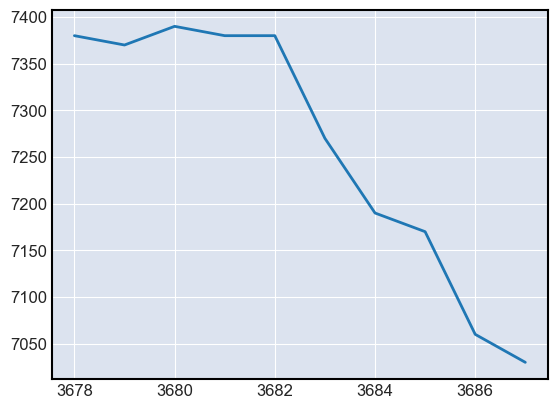

In [84]:
plt.plot(df['open'][-10:])

In [46]:
# change data to be campatible to mplfinance #
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index(df['date'])
df = df.drop(['date'], axis=1)
# df = df.drop(['Unnamed: 0'], axis=1)
df.head()


,open,high,low,adjClose,value,volume,count,yesterday,close
date,,,,,,,,,
2007-02-04,4000.0,4000.0,3600.0,3704.0,640374172370,172898994,2489,4000.0,3704.0
2007-02-05,3778.0,3778.0,3778.0,3778.0,40902501888,10826496,1709,3704.0,3778.0
2007-02-06,3853.0,3853.0,3853.0,3853.0,103453562449,26850133,4118,3778.0,3853.0
2007-02-07,3930.0,3930.0,3930.0,3930.0,122171316570,31086849,4247,3853.0,3930.0
2007-02-10,4008.0,4008.0,4008.0,4008.0,162907276224,40645528,4984,3930.0,4008.0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


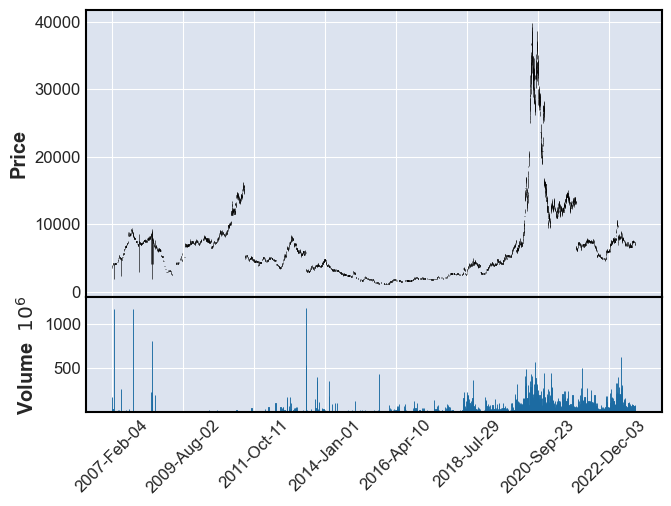

In [47]:
# plot stock price in candlestick chart with mplfinance #
mpf.plot(df, type='candle', volume=True)

In [48]:
df.shape

(3688, 9)

In [49]:
## add ichimoku cload data ##
# add ichimoku cloud data
def ichimoku(df):
    nine_period_high = df['high'].rolling(window= 9).max()
    nine_period_low = df['low'].rolling(window= 9).min()
    df['tenkan_sen'] = (nine_period_high + nine_period_low) /2

    period26_high = df['high'].rolling(window=26).max()
    period26_low = df['low'].rolling(window=26).min()
    df['kijun_sen'] = (period26_high + period26_low) / 2

    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)

    period52_high = df['high'].rolling(window=52).max()
    period52_low = df['low'].rolling(window=52).min()
    df['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26)

    df['chikou_span'] = df['close'].shift(-26)

    return df

train = ichimoku(df)

In [50]:
# moving average indicator #
def moving_average(df):
    df['ma5'] = df['close'].rolling(window=5).mean()
    df['ma10'] = df['close'].rolling(window=10).mean()
    df['ma20'] = df['close'].rolling(window=20).mean()
    df['ma60'] = df['close'].rolling(window=60).mean()
    df['ma120'] = df['close'].rolling(window=120).mean()
    df['ma240'] = df['close'].rolling(window=240).mean()
    return df

train = moving_average(df)


In [51]:
# add RSI data #
def RSI(df):
    U = np.where(df['close'].diff(1) > 0, df['close'].diff(1), 0)
    D = np.where(df['close'].diff(1) < 0, df['close'].diff(1)*(-1), 0)
    AU = pd.DataFrame(U).rolling(window=14, min_periods=14).mean()
    AD = pd.DataFrame(D).rolling(window=14, min_periods=14).mean()
    RSI = AU.div(AD+AU)*100
    df['RSI'] = RSI.values
    return df

train = RSI(df)

In [52]:
# clear train data from NaN and ... #
train = train.dropna()


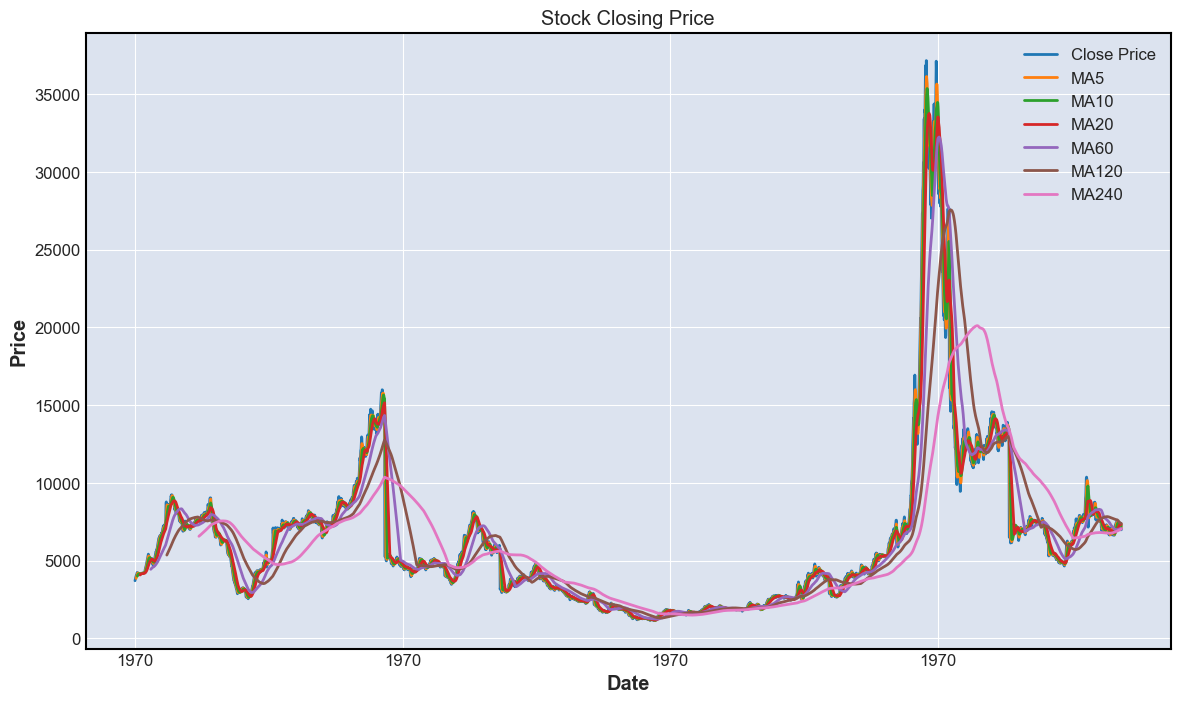

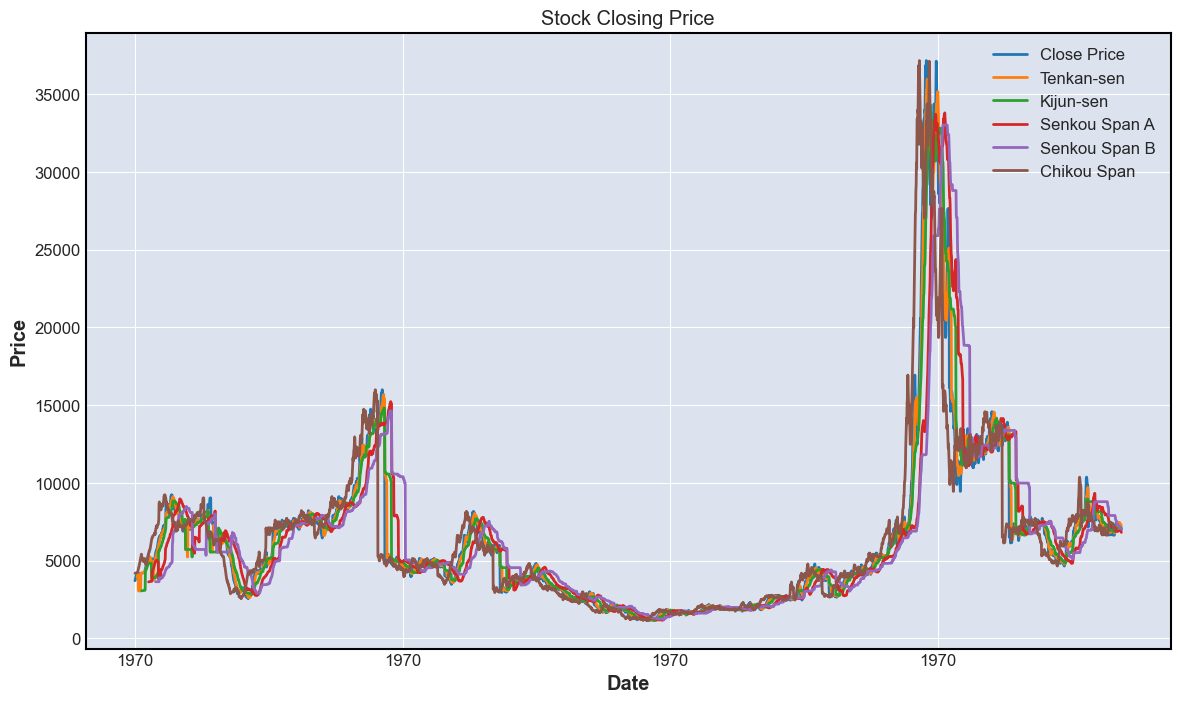

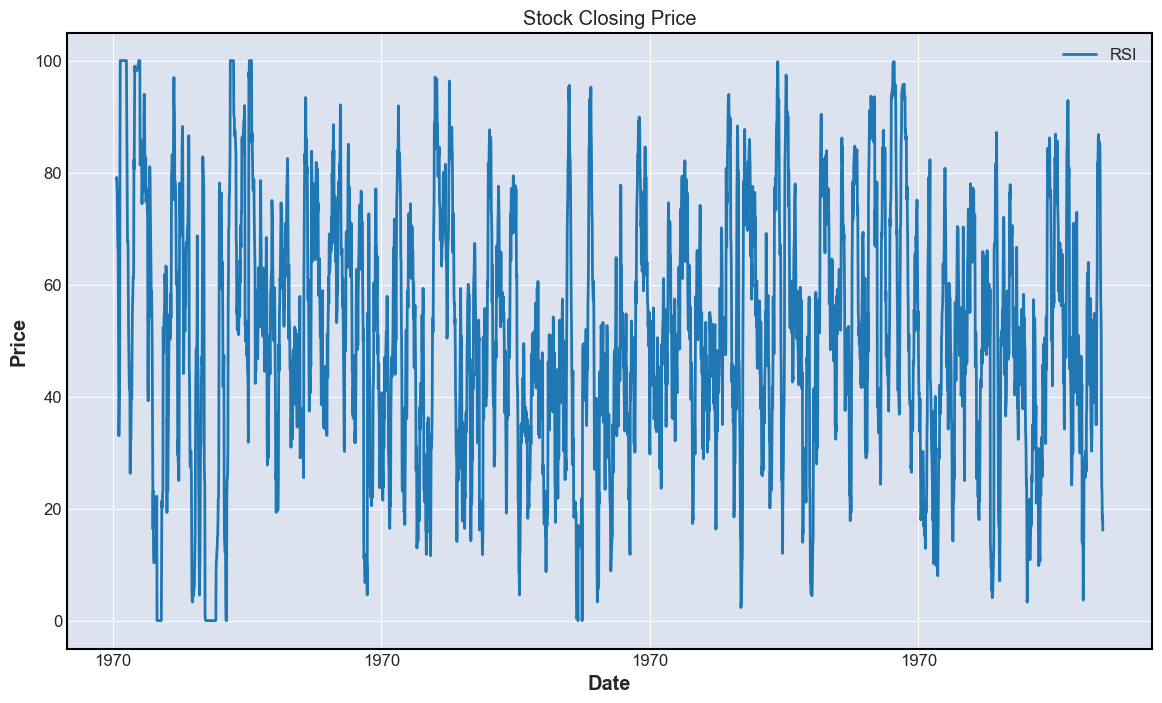

In [53]:
# plot stock in candle with indicator #
def plot_stock(df):
    df = df.reset_index()
    df.index = pd.to_datetime(df.index)
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)
    ax.set_title('Stock Closing Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.plot(df['close'], label='Close Price')
    ax.plot(df['ma5'], label='MA5')
    ax.plot(df['ma10'], label='MA10')
    ax.plot(df['ma20'], label='MA20')
    ax.plot(df['ma60'], label='MA60')
    ax.plot(df['ma120'], label='MA120')
    ax.plot(df['ma240'], label='MA240')
    ax.legend()
    plt.show()

plot_stock(df)

# plot ichimoku cloud #
def plot_ichimoku(df):
    df = df.reset_index()
    df.index = pd.to_datetime(df.index)
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)
    ax.set_title('Stock Closing Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.plot(df['close'], label='Close Price')
    ax.plot(df['tenkan_sen'], label='Tenkan-sen')
    ax.plot(df['kijun_sen'], label='Kijun-sen')
    ax.plot(df['senkou_span_a'], label='Senkou Span A')
    ax.plot(df['senkou_span_b'], label='Senkou Span B')
    ax.plot(df['chikou_span'], label='Chikou Span')
    ax.legend()
    plt.show()

plot_ichimoku(df)

# plot RSI #
def plot_RSI(df):
    df = df.reset_index()
    df.index = pd.to_datetime(df.index)
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)
    ax.set_title('Stock Closing Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.plot(df['RSI'], label='RSI')
    ax.legend()
    plt.show()

plot_RSI(df)

In [54]:
train = train.to_numpy()

In [55]:
# seperate stock, average, ichimoku cloud, RSI from normalized data #
stock_data = train[:, 0:5]
average_data = train[:, 5:11]
ichimoku_data = train[:, 11:17]
RSI_data = train[:, 17:18]



In [56]:
# create data set with 4 sequential 1 month input (stock, average, ichimoku cloud, RSI) and 2 output (mean of close and open data)
def create_dataset(stock_data, average_data, ichimoku_data, RSI_data, look_back=20):
    dataX_stock, dataX_average, dataX_ichimoku, dataX_RSI, dataY = [], [], [], [], []
    for i in range(len(stock_data)-look_back-1):
        a = stock_data[i:(i+look_back), :]
        b = average_data[i:(i+look_back), :]
        c = ichimoku_data[i:(i+look_back), :]
        d = RSI_data[i:(i+look_back), :]
        dataX_stock.append(a)
        dataX_average.append(b)
        dataX_ichimoku.append(c)
        dataX_RSI.append(d)
        # y ---> mean of open and close in a week a (2, n) array
        dataY.append([np.mean(stock_data[i + look_back: i+look_back+5, 0]), np.mean(stock_data[i + look_back: i+look_back+5, 3])])
    return np.array(dataX_stock), np.array(dataX_average), np.array(dataX_ichimoku), np.array(dataX_RSI), np.array(dataY)


In [57]:

# create data set with 4 sequential 1 month input (stock, average, ichimoku cloud, RSI) and 2 output (mean of close and open data)
def create_dataset_train(stock_data, average_data, ichimoku_data, RSI_data, look_back=20):
    dataX_stock, dataX_average, dataX_ichimoku, dataX_RSI, dataY = [], [], [], [], []
    for i in range(len(stock_data)-look_back-1):
        a = stock_data[i:(i+look_back), :]
        b = average_data[i:(i+look_back), :]
        c = ichimoku_data[i:(i+look_back), :]
        d = RSI_data[i:(i+look_back), :]
        dataX_stock.append(a)
        dataX_average.append(b)
        dataX_ichimoku.append(c)
        dataX_RSI.append(d)
        # y ---> mean of open and close in a week a (2, n) array
        print(len(stock_data),i, i + look_back + 5)
        if i == 3385:
            print('hi')
            
        dataY.append([np.mean(stock_data[i + look_back: i+look_back+5, 0]), np.mean(stock_data[i + look_back: i+look_back+5, 3])])
    return np.array(dataX_stock), np.array(dataX_average), np.array(dataX_ichimoku), np.array(dataX_RSI), np.array(dataY)


In [58]:
dataX_stock, dataX_average, dataX_ichimoku, dataX_RSI, dataY = create_dataset_train(stock_data, average_data, ichimoku_data, RSI_data, look_back=20)

3423 0 25
3423 1 26
3423 2 27
3423 3 28
3423 4 29
3423 5 30
3423 6 31
3423 7 32
3423 8 33
3423 9 34
3423 10 35
3423 11 36
3423 12 37
3423 13 38
3423 14 39
3423 15 40
3423 16 41
3423 17 42
3423 18 43
3423 19 44
3423 20 45
3423 21 46
3423 22 47
3423 23 48
3423 24 49
3423 25 50
3423 26 51
3423 27 52
3423 28 53
3423 29 54
3423 30 55
3423 31 56
3423 32 57
3423 33 58
3423 34 59
3423 35 60
3423 36 61
3423 37 62
3423 38 63
3423 39 64
3423 40 65
3423 41 66
3423 42 67
3423 43 68
3423 44 69
3423 45 70
3423 46 71
3423 47 72
3423 48 73
3423 49 74
3423 50 75
3423 51 76
3423 52 77
3423 53 78
3423 54 79
3423 55 80
3423 56 81
3423 57 82
3423 58 83
3423 59 84
3423 60 85
3423 61 86
3423 62 87
3423 63 88
3423 64 89
3423 65 90
3423 66 91
3423 67 92
3423 68 93
3423 69 94
3423 70 95
3423 71 96
3423 72 97
3423 73 98
3423 74 99
3423 75 100
3423 76 101
3423 77 102
3423 78 103
3423 79 104
3423 80 105
3423 81 106
3423 82 107
3423 83 108
3423 84 109
3423 85 110
3423 86 111
3423 87 112
3423 88 113
3423 89 114
3423 

In [60]:
dataY[-1]

array([6700., 6660.])

In [61]:
# print shape of inputs #
print(dataX_stock)
print(dataX_average.shape)
print(dataX_ichimoku.shape)
print(dataX_RSI.shape)

[[[7.72900000e+03 7.73000000e+03 7.62000000e+03 7.62000000e+03
   2.51459663e+09]
  [7.62000000e+03 7.64500000e+03 7.47500000e+03 7.60200000e+03
   3.70758405e+09]
  [7.55200000e+03 7.60200000e+03 7.49500000e+03 7.59200000e+03
   1.80183725e+10]
  ...
  [7.89900000e+03 7.90000000e+03 7.72300000e+03 7.84600000e+03
   3.78572890e+09]
  [7.78200000e+03 8.08100000e+03 7.77400000e+03 8.01600000e+03
   3.32976461e+10]
  [8.03000000e+03 8.09700000e+03 7.91200000e+03 8.00800000e+03
   1.96061239e+10]]

 [[7.62000000e+03 7.64500000e+03 7.47500000e+03 7.60200000e+03
   3.70758405e+09]
  [7.55200000e+03 7.60200000e+03 7.49500000e+03 7.59200000e+03
   1.80183725e+10]
  [7.59200000e+03 7.59400000e+03 7.50000000e+03 7.58300000e+03
   3.35717532e+09]
  ...
  [7.78200000e+03 8.08100000e+03 7.77400000e+03 8.01600000e+03
   3.32976461e+10]
  [8.03000000e+03 8.09700000e+03 7.91200000e+03 8.00800000e+03
   1.96061239e+10]
  [8.05000000e+03 8.23900000e+03 7.97000000e+03 8.09500000e+03
   1.75002825e+10]]



In [62]:
# normalize eatch data #
scaler_stock = MinMaxScaler(feature_range=(0, 1))
scaler_average = MinMaxScaler(feature_range=(0, 1))
scaler_ichimoku = MinMaxScaler(feature_range=(0, 1))
scaler_RSI = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

dataX_stock = scaler_stock.fit_transform(dataX_stock.reshape(-1, 5)).reshape(-1, 20, 5)
dataX_average = scaler_average.fit_transform(dataX_average.reshape(-1, 6)).reshape(-1, 20, 6)
dataX_ichimoku = scaler_ichimoku.fit_transform(dataX_ichimoku.reshape(-1, 6)).reshape(-1, 20, 6)
dataX_RSI = scaler_RSI.fit_transform(dataX_RSI.reshape(-1, 1)).reshape(-1, 20, 1)
dataY = scaler_y.fit_transform(dataY)


In [71]:
# last 20 day data for predict #
last_20_day = train[-20:, :]
stock_last_20_day = dataX_stock[-20:, :]
average_last_20_day = dataX_average[-20:, :]
ichimoku_last_20_day = dataX_ichimoku[-20:, :]
RSI_last_20_day = dataX_RSI[-20:, :]
# reshape data to be compatible to model #
stock_last_20_day = stock_last_20_day.reshape(-1, 20, 5)
average_last_20_day = average_last_20_day.reshape(-1, 20, 6)
ichimoku_last_20_day = ichimoku_last_20_day.reshape(-1, 20, 6)
RSI_last_20_day = RSI_last_20_day.reshape(-1, 20, 1)


In [85]:
# load model #
model = load_model('model_folad_4_oct.h5')

In [86]:
# predict #
Predict_data = model.predict([stock_last_20_day, average_last_20_day, ichimoku_last_20_day, RSI_last_20_day])
trainPredict = scaler_y.inverse_transform(Predict_data)
print('open and close: ', trainPredict[-1, :])

1/1 [==============================] - 4s 4s/step
open and close:  [6935.6963 6924.9375]


In [80]:
plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


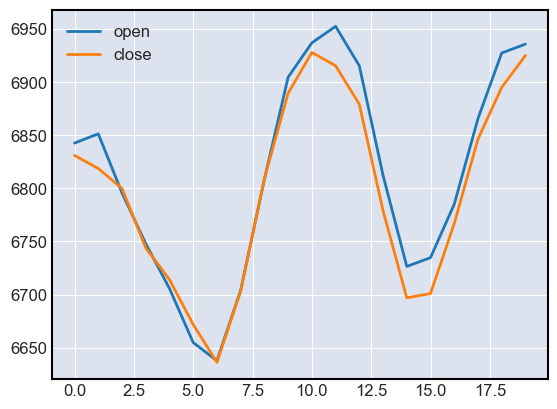

In [87]:
# plot open + close 
plt.plot(trainPredict[:, 0], label='open')
plt.plot(trainPredict[:, 1], label='close')
plt.legend()
plt.show()



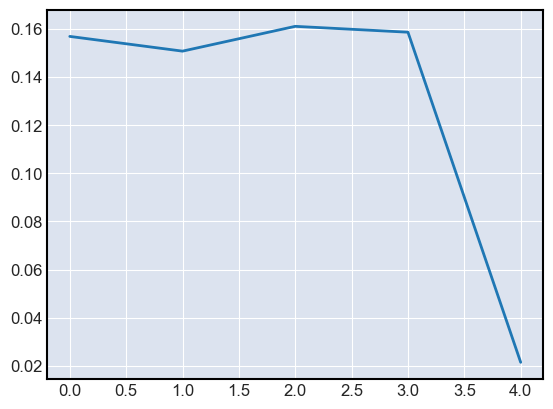

In [90]:
plt.plot(stock_last_20_day[0, 1])